# **Heart Disease Health Indicators Data Modeling - Gradient Boosting**

We aim to develop a predictive model that can accurately identify individuals who are at a higher risk of developing heart disease. We will use various machine learning algorithms to train our models and evaluate their performance using different metrics. The ultimate goal is to create a model that can be used by healthcare providers to identify high-risk patients and intervene early to prevent heart disease.

In [1]:
# General Libraries
import time
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, SMOTEN)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours,
                                    RandomUnderSampler) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Load and read the data
heart_data = pd.read_csv('../data/2021_brfss_ohe_heart_disease_health_indicators.csv')
heart_data.head()

,target,HighBP,HighChol,CholCheck,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,income_grp_10k-15k USD,income_grp_150k-200k USD,income_grp_15k-20k USD,income_grp_200k USD or more,income_grp_20k-25k USD,income_grp_25k-35k USD,income_grp_35k-50k USD,income_grp_50k-75k USD,income_grp_75k-100k USD,income_grp_Less than 10k USD
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


## Proportion Chance Criterion

Would Recommend:          0
0.0  200163
1.0   20248
Proportion Chance Criterion: 83.31%
1.25 * Proportion Chance Criterion: 104.14%


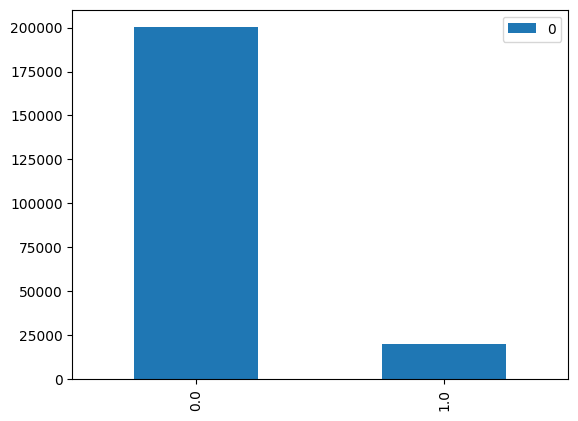

In [3]:
state_counts = Counter(heart_data['target'])
heart_data_state = pd.DataFrame.from_dict(state_counts, orient='index')
heart_data_state.plot(kind='bar')

num=(heart_data_state[0]/heart_data_state[0].sum())**2

print("Would Recommend:{}".format(heart_data_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

## Data Splitting

In [3]:
# Separate the feature and target variables
X = heart_data.drop(['target'], axis=1)
y = heart_data['target']

In [4]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                            random_state=42, 
                                                            test_size=0.20,
                                                            stratify=y)

In [5]:
# Check the train-val data
X_trainval.head()

,HighBP,HighChol,CholCheck,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthInsurance,...,income_grp_10k-15k USD,income_grp_150k-200k USD,income_grp_15k-20k USD,income_grp_200k USD or more,income_grp_20k-25k USD,income_grp_25k-35k USD,income_grp_35k-50k USD,income_grp_50k-75k USD,income_grp_75k-100k USD,income_grp_Less than 10k USD
22913,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
206459,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,1,0,0,0
3667,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0
86209,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
29322,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0


## Build and Train the Model with Auto ML

In [6]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {} # for plots/viz results
    results2 = {} # table results

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        # accuracy scores
        train_scores = []
        val_scores = []

        # recall scores
        train_recall = []
        val_recall = []
        
        # precision scores
        train_prec = []
        val_prec = []
        
        #f1 scores
        train_f1 = []
        val_f1 = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling to standardize values
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else: # else use raw data
                pass 

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            # precision
            train_prec.append(precision_score(y_train, train_preds))
            val_prec.append(precision_score(y_val, val_preds))
            
            # f1
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))
            
            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train Precision': np.round(np.mean(train_prec) * 100, 2),
                'Val Precision': np.round(np.mean(val_prec) * 100, 2),
                'Train F1 Score': np.round(np.mean(train_f1) * 100, 2),
                'Val F1 Score': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_prec)*100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_prec)*100, 2)),
                'Train F1 Score': '{:.2f}%'.format(np.round(np.mean(train_f1)*100, 2)),
                'Val F1 Score': '{:.2f}%'.format(np.round(np.mean(val_f1)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

### Baseline Model

In [7]:
models_dict = {
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)
}

In [8]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, cv=StratifiedKFold(n_splits=5))

auto = auto_run[0]
auto_run[1] # table results

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,25.218771,91.01%,15.65%,56.76%,9.08%,90.95%,15.10%,54.78%,8.76%


In [ ]:
auto_run

## Applying Resampling Techniques

### Undersampling

#### Random Undersampling

In [9]:
res_list = [('RandomUnderSampler', RandomUnderSampler())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict,
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

--------------------------------------------RandomUnderSampler---------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.08580803871154785
Resampling done in 0.08125758171081543
Resampling done in 0.08220577239990234
Resampling done in 0.10371065139770508
Resampling done in 0.11137700080871582


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,4.217445,76.75%,77.55%,74.97%,80.31%,73.19%,35.36%,22.71%,79.81%


In [10]:
# Recall
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[0]['Val Recall']
ps_under['RandomUnderSampler Val Recall'] = outputs_u[0]['Val Recall']
ps_under

,NoResampling Val Recall,RandomUnderSampler Val Recall
GradientBoostingClassifier,8.76,79.81


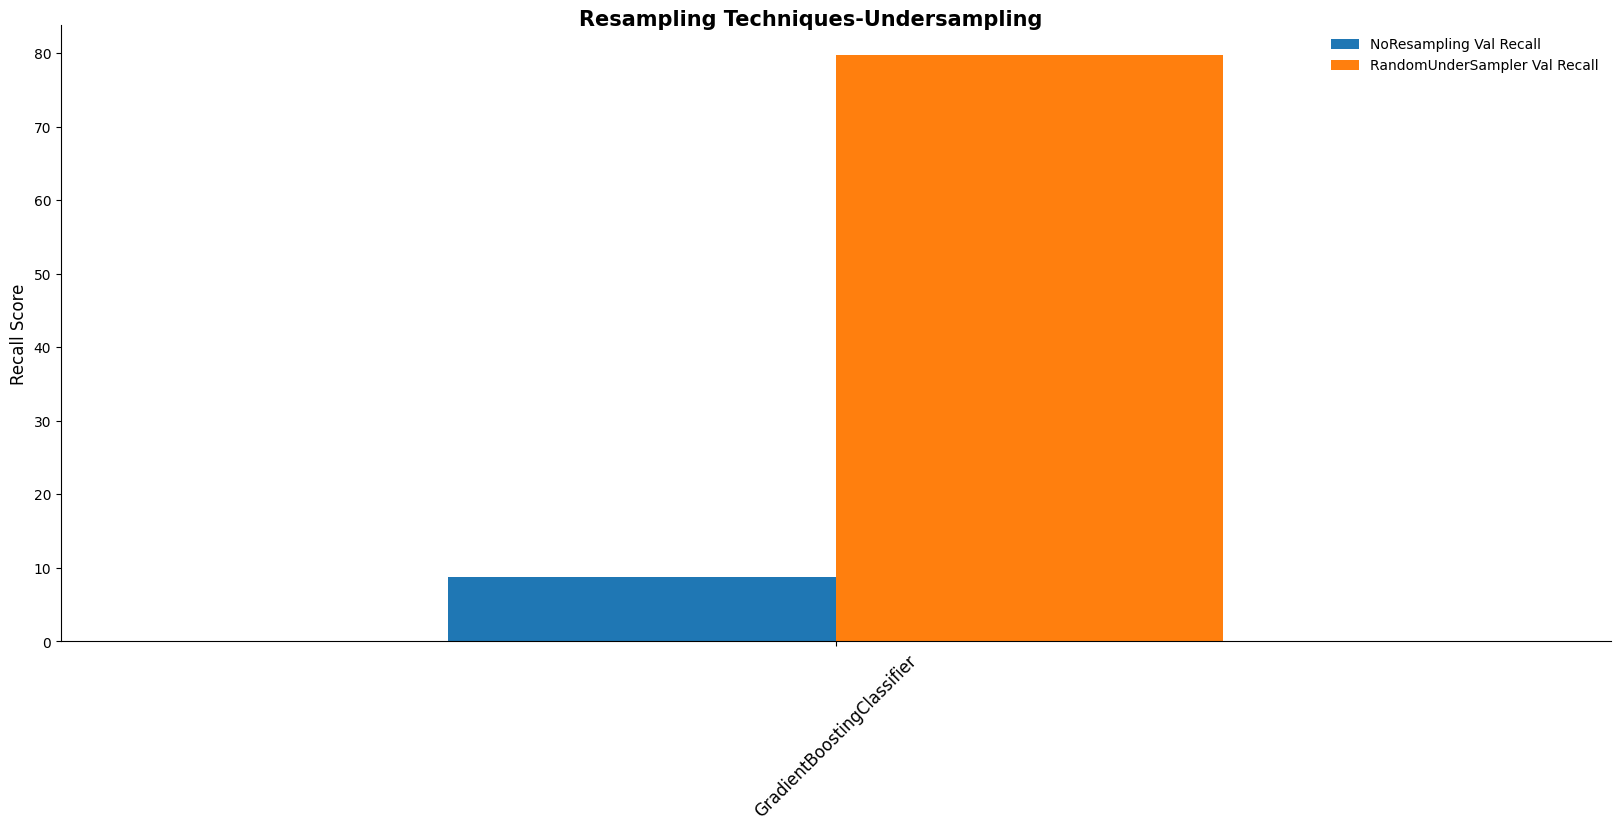

In [11]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [12]:
# Accuracy
ps_under_acc = pd.DataFrame(index=models_dict.keys())
ps_under_acc['NoResampling Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_under_acc['RandomUnderSampler Val Accuracy'] = outputs_u[0]['Val Accuracy']
ps_under_acc

,NoResampling Val Accuracy,RandomUnderSampler Val Accuracy
GradientBoostingClassifier,90.95,73.19


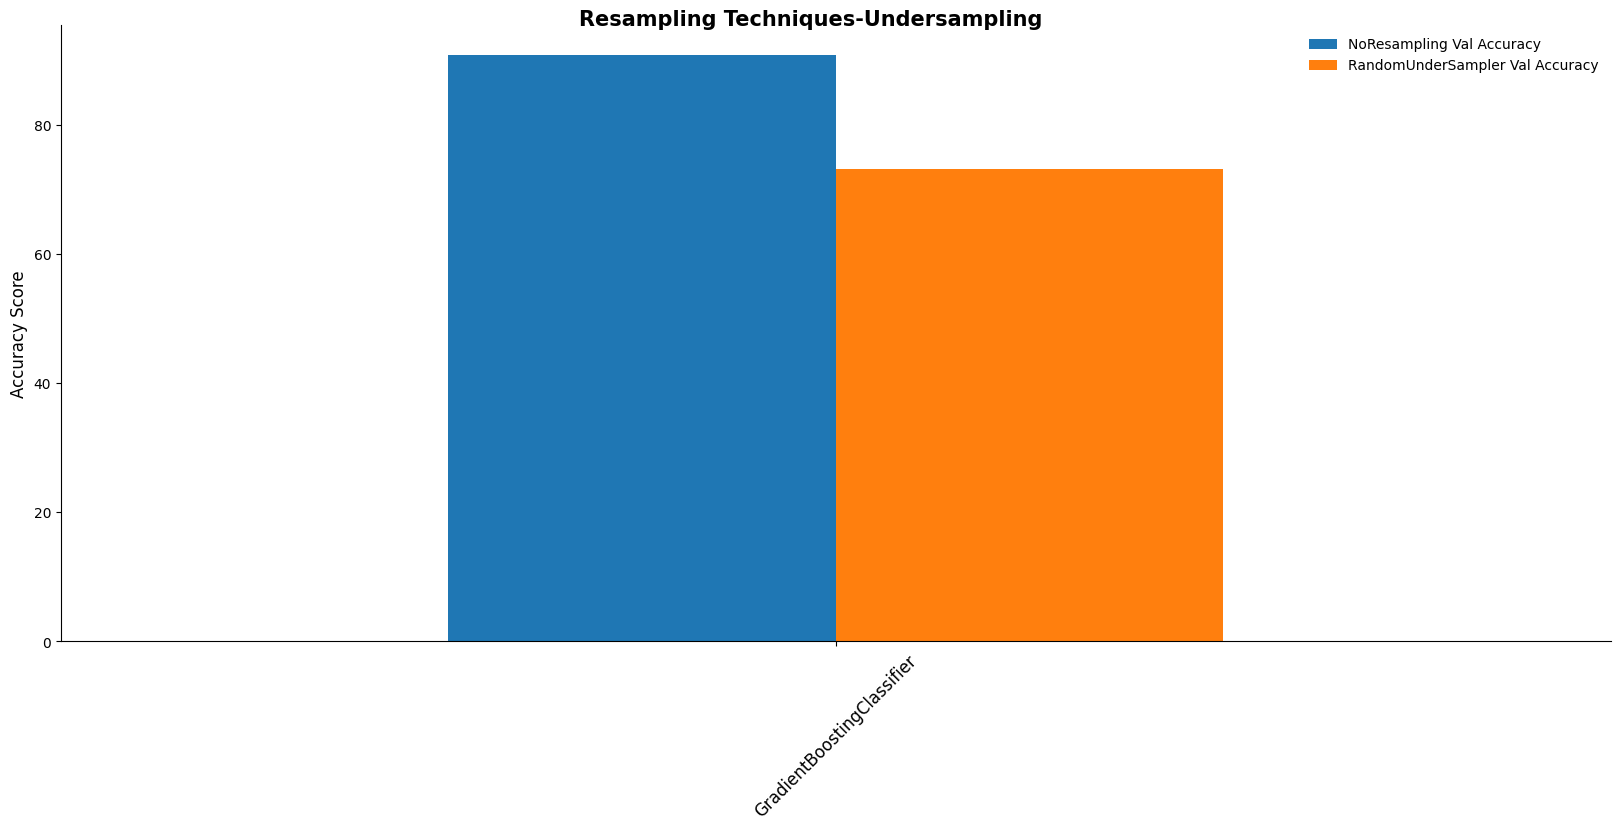

In [13]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### TomekLinks and NearMiss

In [10]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict,
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 39.65026092529297
Resampling done in 47.21736025810242
Resampling done in 47.607983350753784
Resampling done in 26.483015298843384
Resampling done in 25.971426725387573


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,45.661431,90.93%,19.30%,58.39%,11.56%,90.90%,18.34%,52.27%,11.12%


-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 2.728602170944214
Resampling done in 2.606144666671753
Resampling done in 2.737359046936035
Resampling done in 2.7933452129364014
Resampling done in 2.9026784896850586


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,7.607445,86.24%,85.18%,92.30%,79.07%,37.98%,18.94%,10.76%,78.88%


In [11]:
# Recall
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[0]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']
ps_under

,NoResampling Val Recall,TomekLinks Val Recall,NearMiss Val Recall
GradientBoostingClassifier,8.76,11.12,78.88


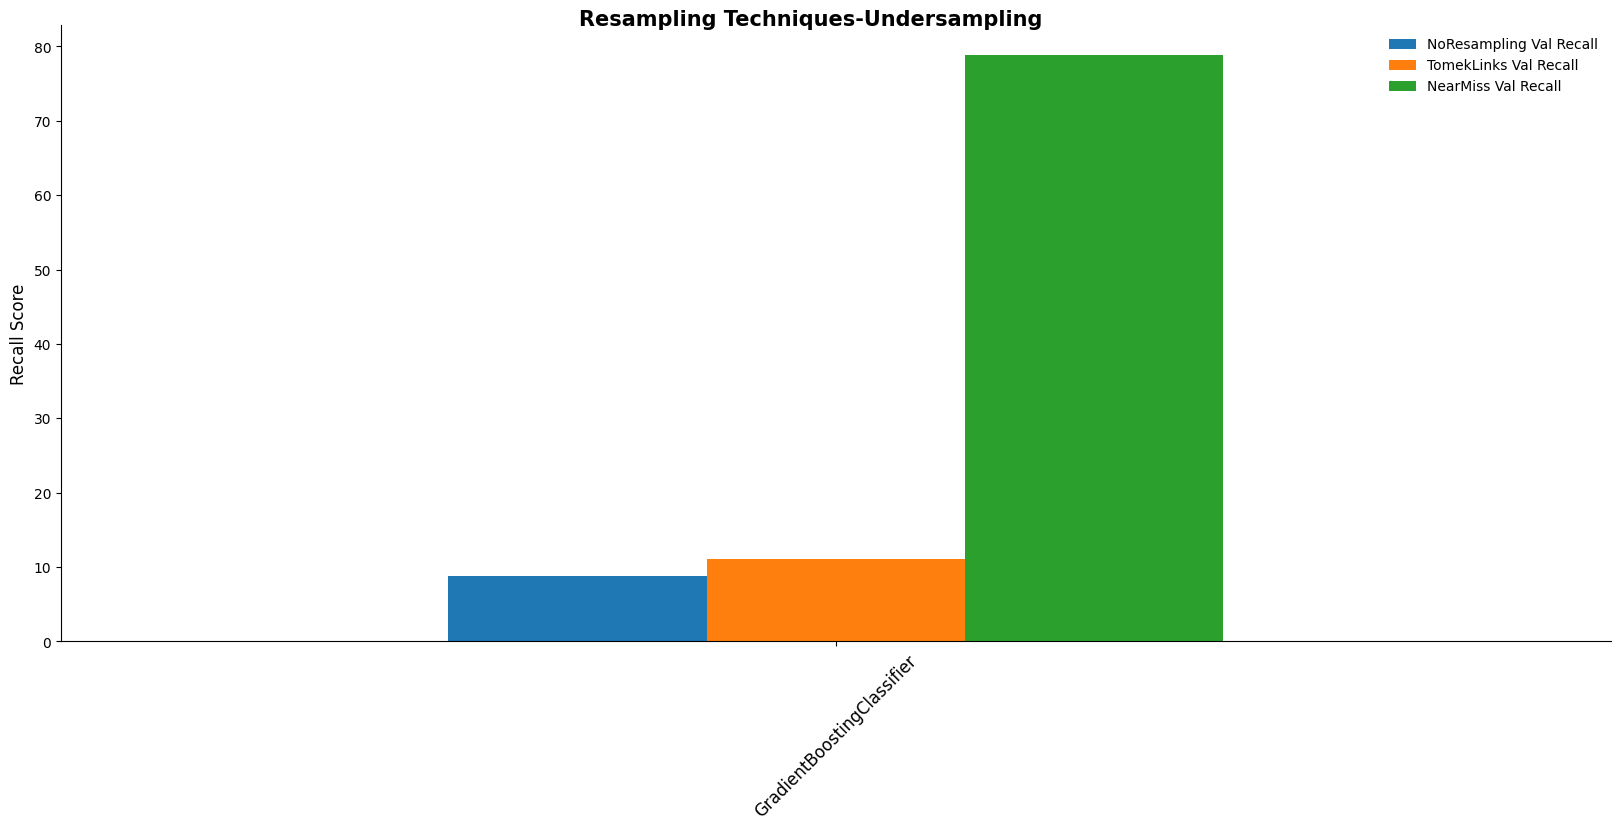

In [12]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [13]:
# Accuracy
ps_under_acc = pd.DataFrame(index=models_dict.keys())
ps_under_acc['NoResampling Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_under_acc['TomekLinks Val Accuracy'] = outputs_u[0]['Val Accuracy']
ps_under_acc['NearMiss Val Accuracy'] = outputs_u[1]['Val Accuracy']
ps_under_acc

,TomekLinks Val Accuracy,NearMiss Val Accuracy
GradientBoostingClassifier,90.9,37.98


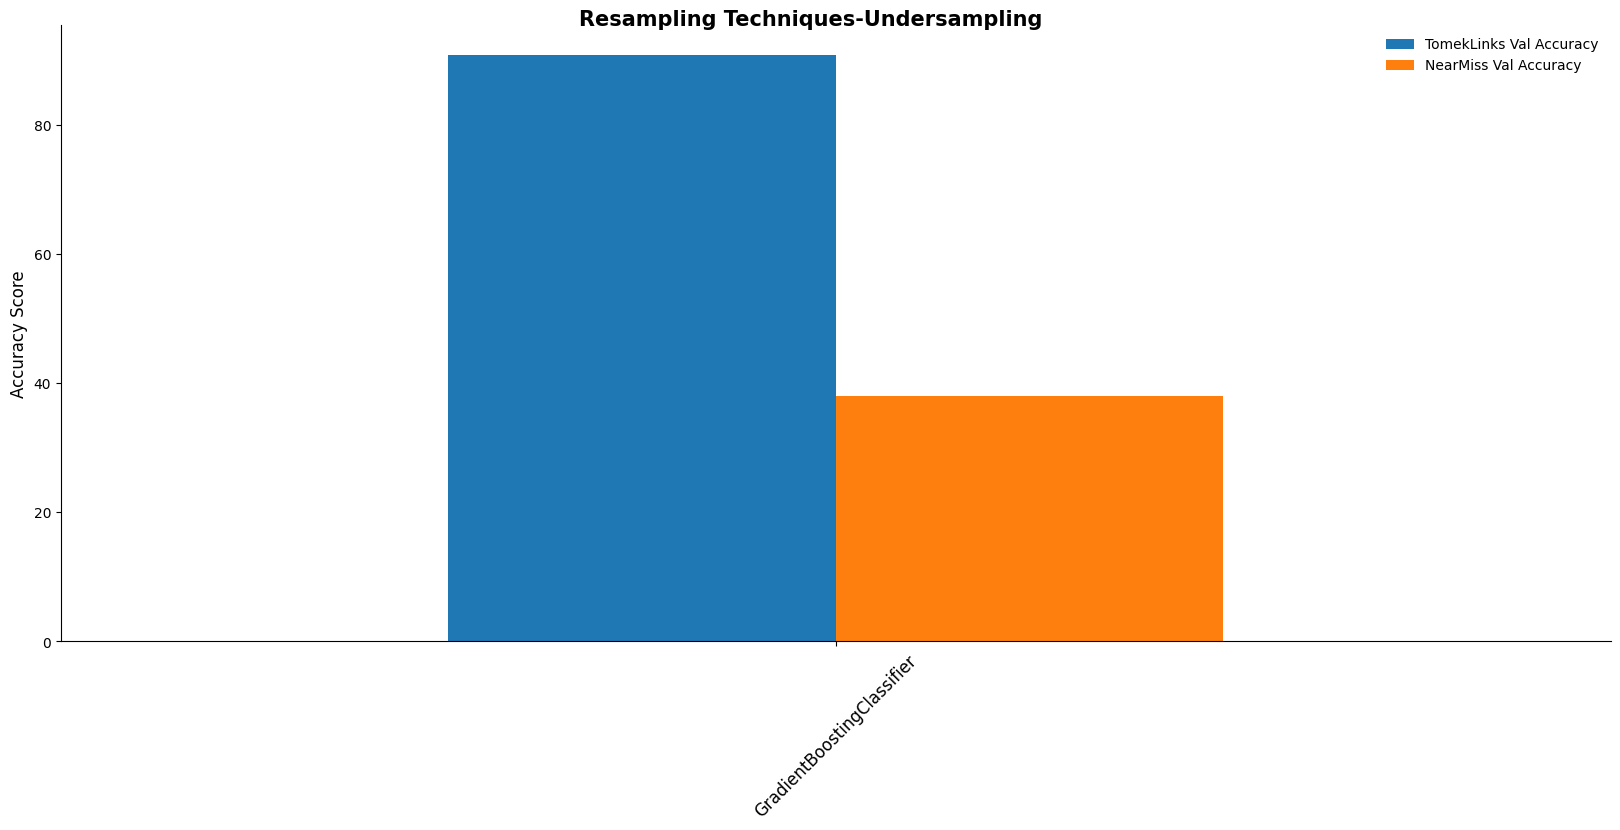

In [14]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

### Oversampling

#### SMOTE and ADASYN

In [15]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, 
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 1.2268187999725342
Resampling done in 6.3783252239227295
Resampling done in 1.2185468673706055
Resampling done in 1.1332404613494873
Resampling done in 1.1877391338348389


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,115.281375,89.91%,89.83%,90.61%,89.06%,86.45%,37.37%,32.49%,44.00%


--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 4.533873558044434
Resampling done in 4.4671854972839355
Resampling done in 4.376806974411011
Resampling done in 4.682795763015747
Resampling done in 5.190840005874634


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,118.061657,89.82%,89.70%,90.58%,88.83%,86.43%,37.07%,32.30%,43.48%


In [16]:
# Accuracy
ps_over_acc = pd.DataFrame(index=models_dict.keys())
ps_over_acc['Baseline Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_over_acc['SMOTE Val Accuracy'] = outputs[0]['Val Accuracy']
ps_over_acc['ADASYN Val Accuracy'] = outputs[1]['Val Accuracy']
ps_over_acc

,Baseline Val Accuracy,SMOTE Val Accuracy,ADASYN Val Accuracy
GradientBoostingClassifier,90.95,86.45,86.43


In [ ]:
# ps_over_acc.to_csv('ps_over_acc.csv', index=False)

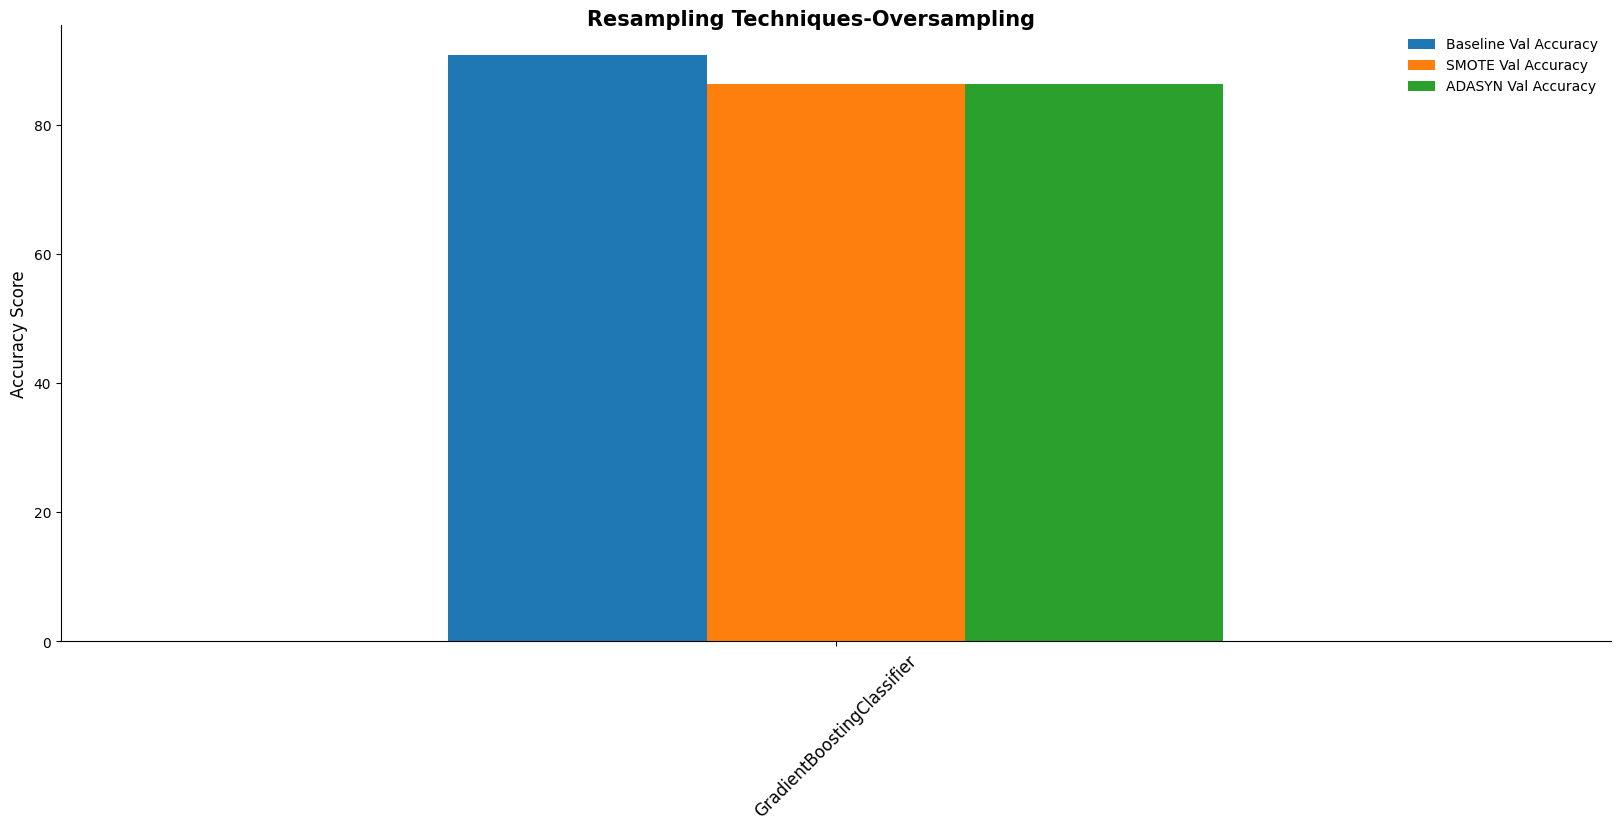

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [18]:
# Recall
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['Baseline Val Recall'] = auto_run[0]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
ps_over

,Baseline Val Recall,SMOTE Val Recall,ADASYN Val Recall
GradientBoostingClassifier,8.76,44.0,43.48


In [ ]:
# ps_over.to_csv('ps_over_rec.csv', index=False)

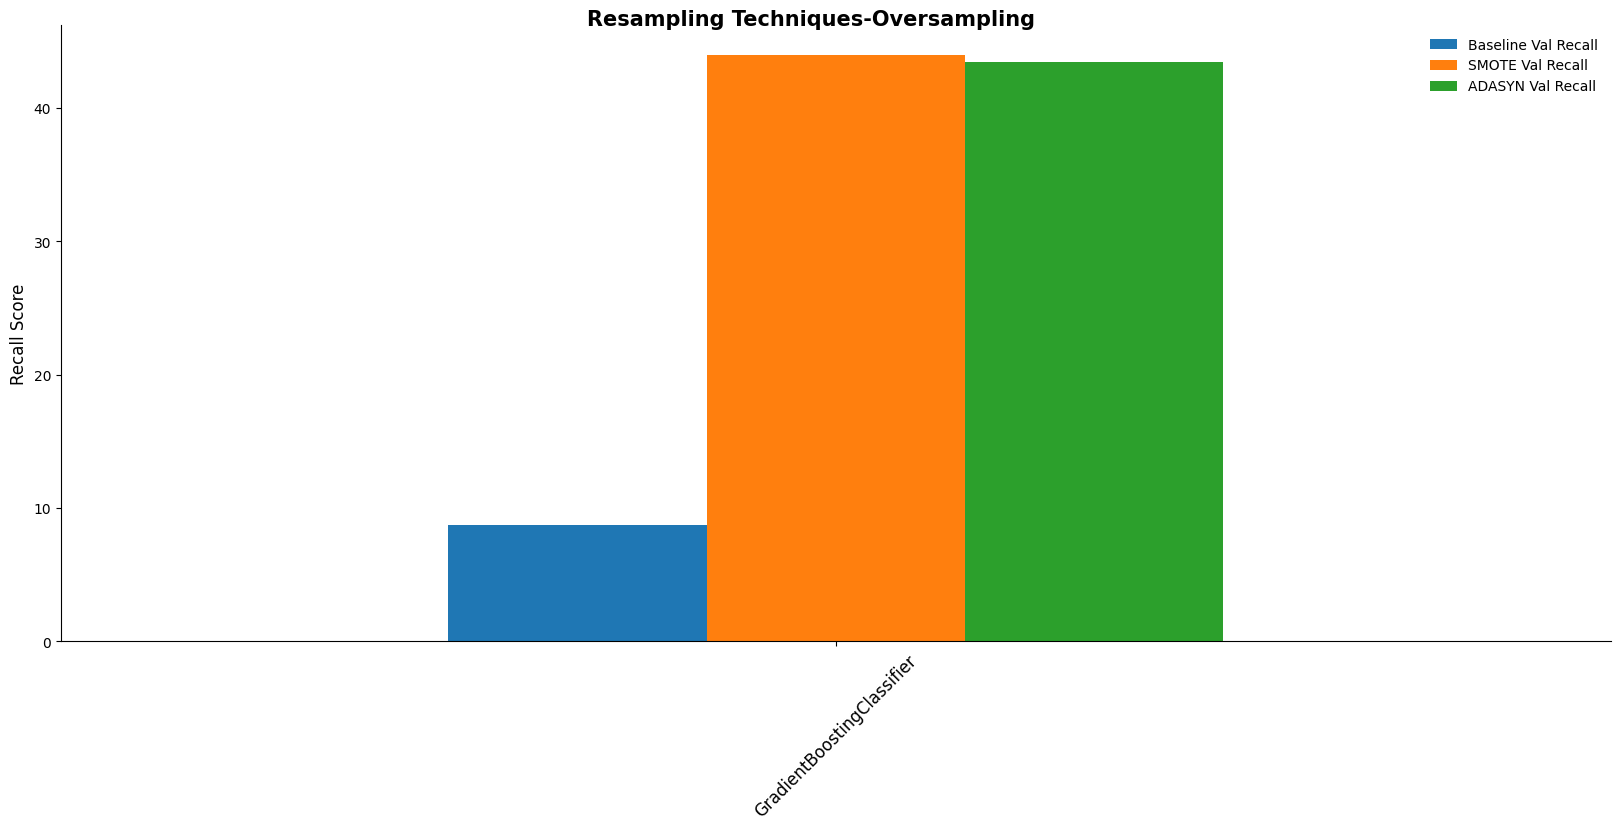

In [19]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [ ]:
outputs

#### SMOTEN

In [ ]:
res_list = [('SMOTEN', SMOTEN())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, 
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

--------------------------------------------------SMOTEN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 372.440034866333


In [ ]:
# Accuracy
ps_over_acc = pd.DataFrame(index=models_dict.keys())
ps_over_acc['Baseline Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_over_acc['SMOTEN Val Accuracy'] = outputs[0]['Val Accuracy']
ps_over_acc['ADASYN Val Accuracy'] = outputs[1]['Val Accuracy']
ps_over_acc['SMOTEN Val Accuracy'] = outputs[2]['Val Accuracy']
ps_over_acc

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [ ]:
# Recall
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['Baseline Val Recall'] = auto_run[0]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
ps_over['SMOTEN Val Recall'] = outputs[1]['Val Recall']
ps_over

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

## Hyperparameter Tuning

In [14]:
def train_gb(X, y, metric, res_t=None, hypertune=False, resample=False):
    params = {"n_estimators": [1, 10, 50, 100, 200],
              "learning_rate": [1, 0.5, 0.1, 0.01]
             }
    new_params = {'gradientboostingclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      GradientBoostingClassifier(random_state=143))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      GradientBoostingClassifier(random_state=143))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Gradient Boosting Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['Gradient Boosting Classifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

### Random Undersampling

In [15]:
start_time_gb = time.time()
gb_us_rec = train_gb(X_trainval, y_trainval, 'recall', RandomUnderSampler(),
                       hypertune=True, resample=True)
end_time_gb = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.697, test=0.701) total time=   0.2s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.727, test=0.718) total time=   0.2s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.723, test=0.734) total time=   0.2s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

In [16]:
gb_us_rec

['Gradient Boosting Classifier',
 0.7750647782496045,
 0.7970732660209865,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__n_estimators': 200}",
 419.5217664241791,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomundersampler', RandomUnderSampler()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(n_estimators=200,
                                             random_state=143))])]

In [17]:
start_time_gb1 = time.time()
gb_us_acc = train_gb(X_trainval, y_trainval, 'accuracy', RandomUnderSampler(),
                      hypertune=True, resample=True)
end_time_gb1 = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.684, test=0.685) total time=   0.2s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.685, test=0.681) total time=   0.2s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.695, test=0.701) total time=   0.3s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

In [18]:
gb_us_acc

['Gradient Boosting Classifier',
 0.7132050757974973,
 0.7334399315038604,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__n_estimators': 100}",
 382.34068155288696,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomundersampler', RandomUnderSampler()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(random_state=143))])]

In [19]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [gb_us_rec[0],
                np.round(gb_us_acc[1]*100, 6),
                np.round(gb_us_acc[2]*100, 6),
                np.round(gb_us_rec[1]*100, 6),
                np.round(gb_us_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [gb_us_rec[0],
                 '{:.2f}%'.format(np.round(gb_us_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Gradient Boosting Classifier,71.32%,73.34%,77.51%,79.71%


In [20]:
# re-fitting for the holdout
rh = gb_us_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

In [21]:
# cross-validation
base_var = train_gb(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [22]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(gb_us_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,9.08%,8.76%,8.77%
Resampling x Hypertune,77.51%,79.71%,78.89%


### NearMiss

In [22]:
start_time_gb = time.time()
gb_tk_rec = train_gb(X_trainval, y_trainval, 'recall', NearMiss(),
                       hypertune=True, resample=True)
end_time_gb = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.638, test=0.648) total time=   2.9s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.630, test=0.622) total time=   3.1s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.629, test=0.626) total time=   3.0s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

In [23]:
gb_tk_rec

['Gradient Boosting Classifier',
 0.7312932310613689,
 0.7968886335136207,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 0.5, 'gradientboostingclassifier__n_estimators': 200}",
 1039.3781895637512,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('nearmiss', NearMiss()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(learning_rate=0.5, n_estimators=200,
                                             random_state=143))])]

In [24]:
start_time_gb1 = time.time()
gb_tk_acc = train_gb(X_trainval, y_trainval, 'accuracy', NearMiss(),
                      hypertune=True, resample=True)
end_time_gb1 = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.507, test=0.506) total time=   2.9s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.533, test=0.537) total time=   3.0s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.533, test=0.536) total time=   4.7s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

In [25]:
gb_tk_acc

['Gradient Boosting Classifier',
 0.45581656691004974,
 0.5435949912463298,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__n_estimators': 100}",
 1002.9559097290039,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('nearmiss', NearMiss()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(learning_rate=0.01,
                                             random_state=143))])]

In [26]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [gb_tk_rec[0],
                np.round(gb_tk_acc[1]*100, 6),
                np.round(gb_tk_acc[2]*100, 6),
                np.round(gb_tk_rec[1]*100, 6),
                np.round(gb_tk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [gb_tk_rec[0],
                 '{:.2f}%'.format(np.round(gb_tk_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Gradient Boosting Classifier,45.58%,54.36%,73.13%,79.69%


In [27]:
# re-fitting for the holdout
rh = gb_tk_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

In [28]:
# cross-validation
base_var = train_gb(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [29]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(gb_tk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,9.08%,8.76%,8.77%
Resampling x Hypertune,73.13%,79.69%,79.09%


### SMOTEN

In [ ]:
start_time_sm = time.time()
gb_sm_rec = train_gb(X_trainval, y_trainval, 'recall', SMOTEN(),
                       hypertune=True, resample=True)
end_time_sm = time.time()

In [ ]:
gb_sm_rec

In [ ]:
start_time_sm1 = time.time()
gb_sm_acc = train_gb(X_trainval, y_trainval, 'accuracy', SMOTEN(),
                      hypertune=True, resample=True)
end_time_sm1 = time.time()

In [ ]:
gb_sm_acc

In [ ]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper3 = pd.DataFrame(columns=cols)
hyper3.loc[0] = [gb_sm_rec[0],
                np.round(gb_sm_acc[1]*100, 6),
                np.round(gb_sm_acc[2]*100, 6),
                np.round(gb_sm_acc[1]*100, 6),
                np.round(gb_sm_acc[2]*100, 6)]
hyper4 = pd.DataFrame(columns=cols)
hyper4.loc[0] = [gb_sm_rec[0],
                 '{:.2f}%'.format(np.round(gb_sm_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_sm_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_sm_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_sm_acc[2]*100, 2))]
hyper4.style.hide_index()

In [ ]:
# re-fitting for the holdout
rh = gb_sm_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds1 = rh.predict(X_holdout)
rh_holdout_score1 = recall_score(y_holdout, y_preds)

In [ ]:
# cross-validation
base_var = train_gb(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [ ]:
cols1 = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary1 = pd.DataFrame(columns=cols)
summary1.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary1.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(gb_sm_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_sm_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score1*100, 2))]
summary1.style.hide_index()

## Save the Model

In [26]:
model = rh['gradientboostingclassifier']
pickle.dump(model, open('gb_us.pkl', 'wb'))

## Model Explainability

### Feature Importance

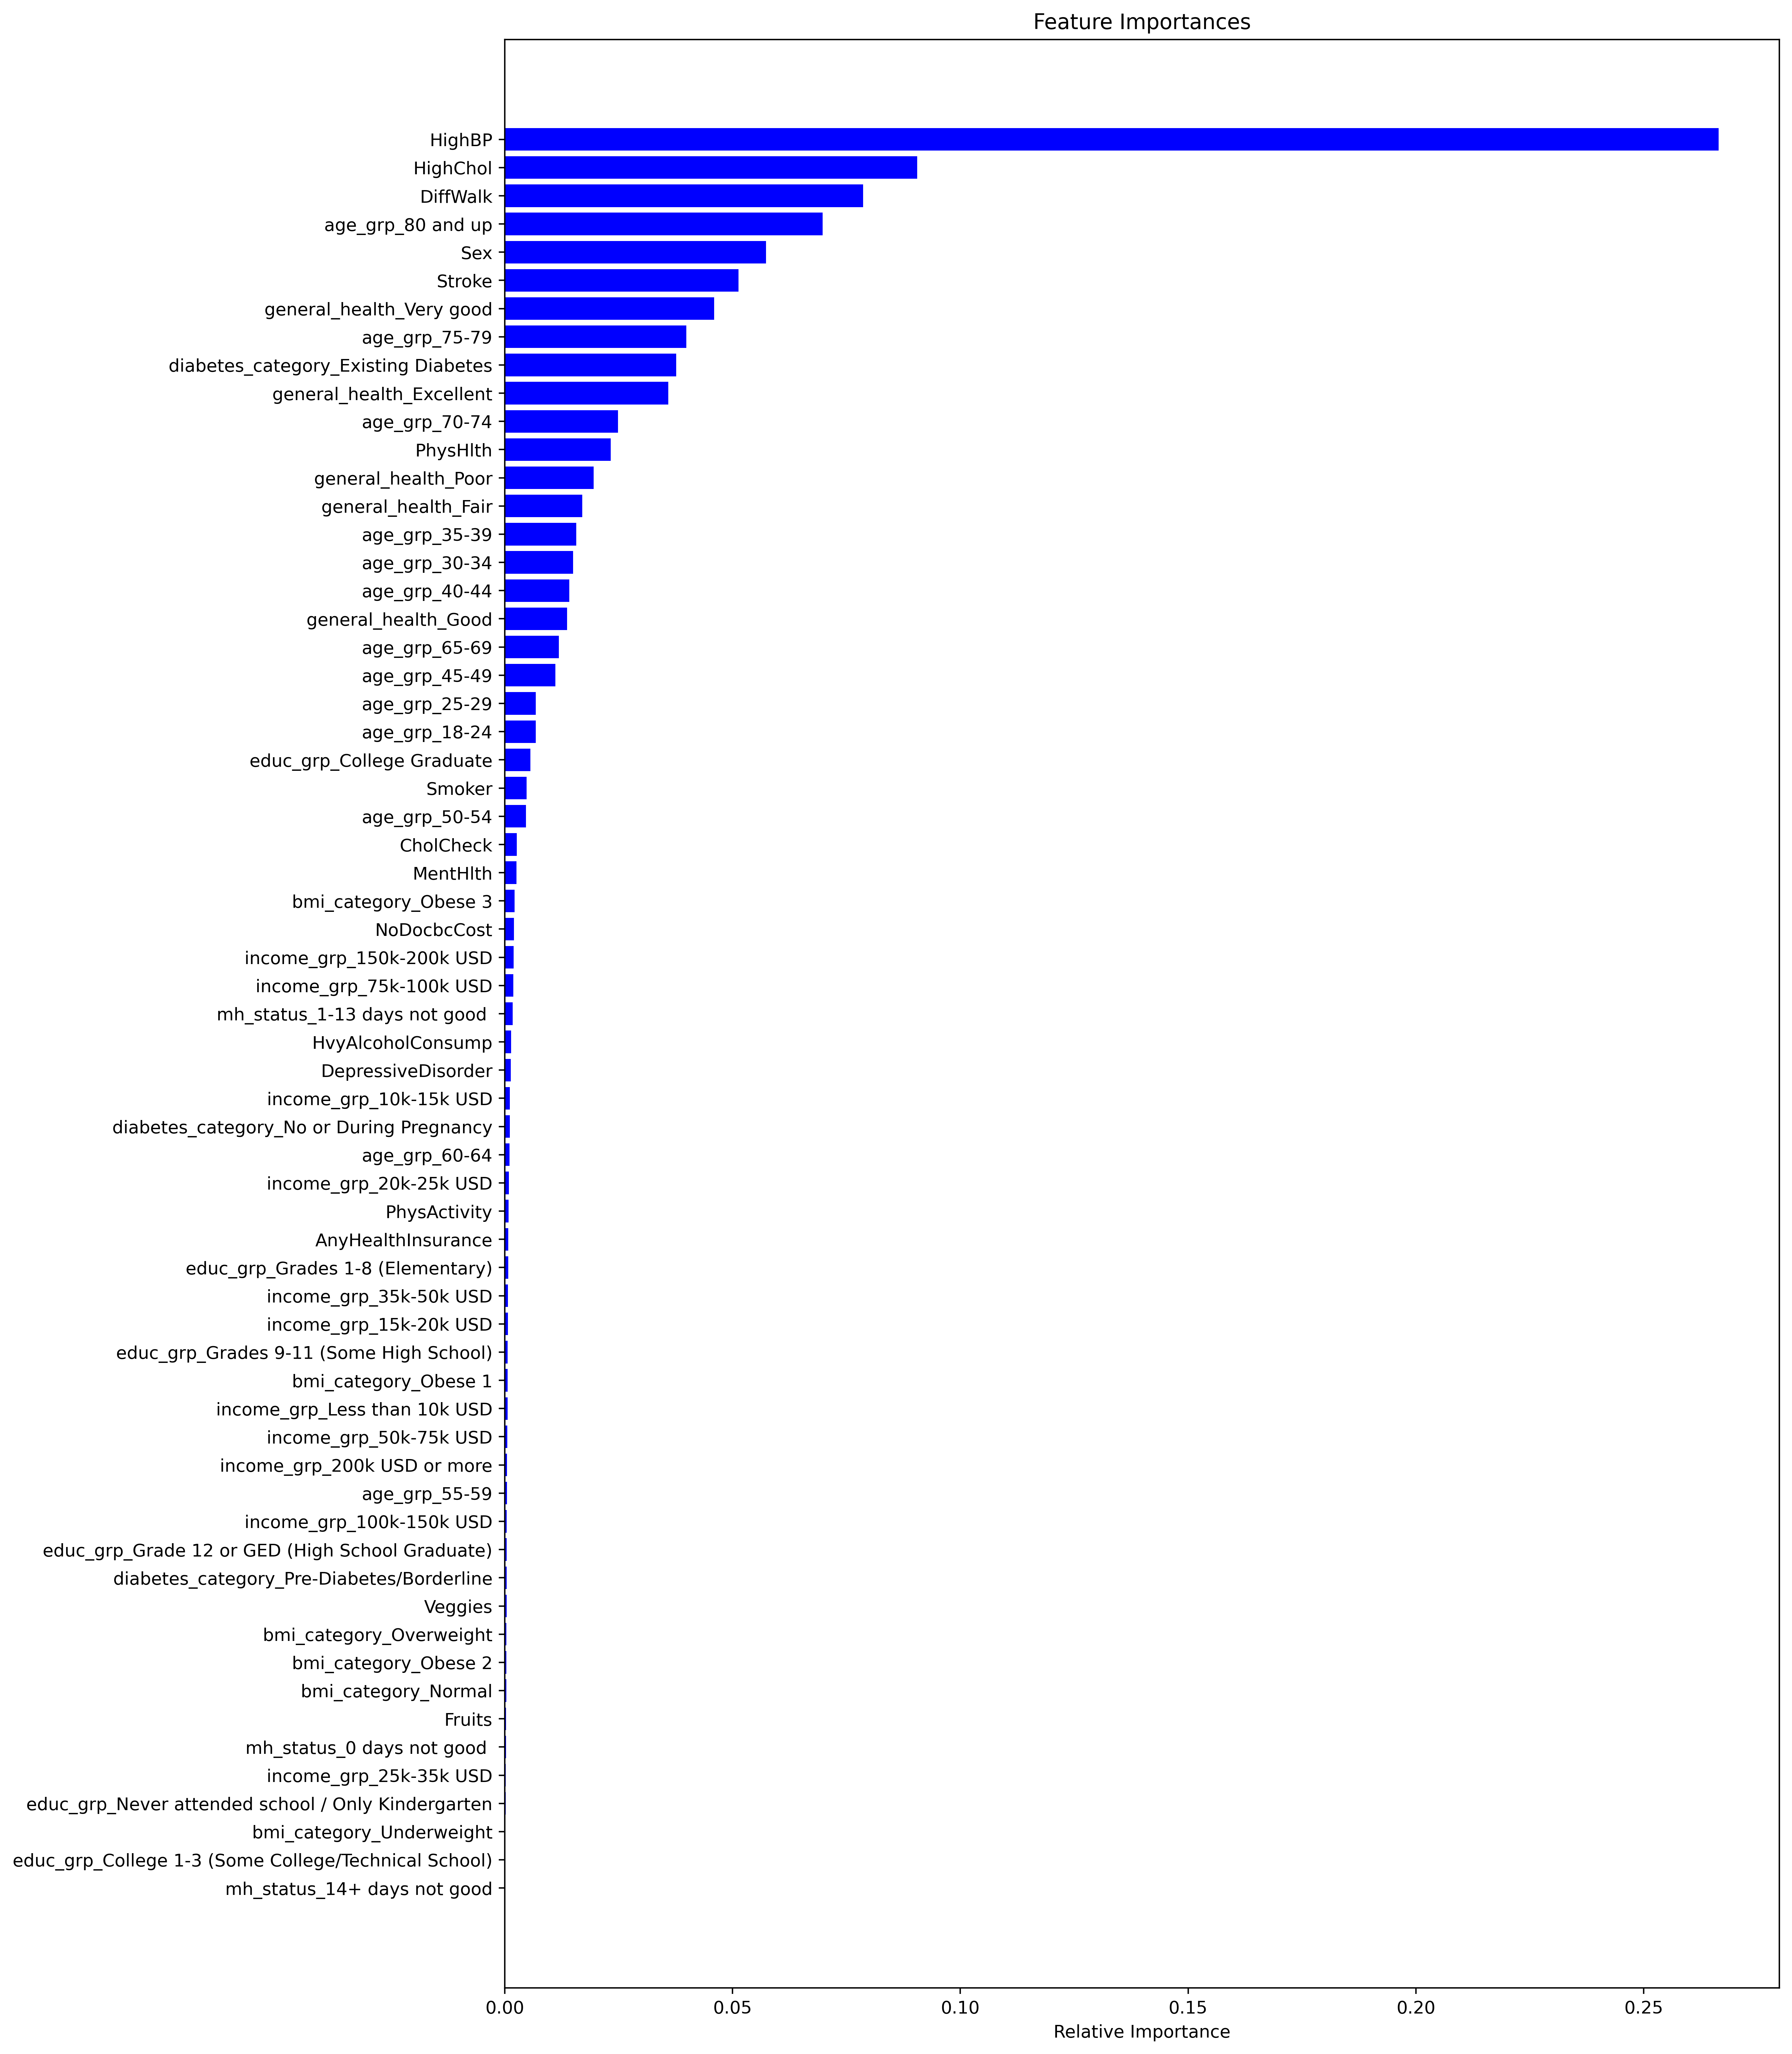

In [24]:
fig, ax = plt.subplots(figsize=(13, 20), dpi=400)

# print(model.feature_importances_)
importances = model.feature_importances_
indices = np.argsort(importances)
features = X_trainval.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### SHAP

#### Force Plot

In [23]:
shap.initjs()

model = rh['gradientboostingclassifier']
explainer = shap.TreeExplainer(model, feature_names=X_holdout.columns)
shap_values = explainer.shap_values(X_holdout.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values, X_holdout.iloc[0,:])

#### Summary Plot

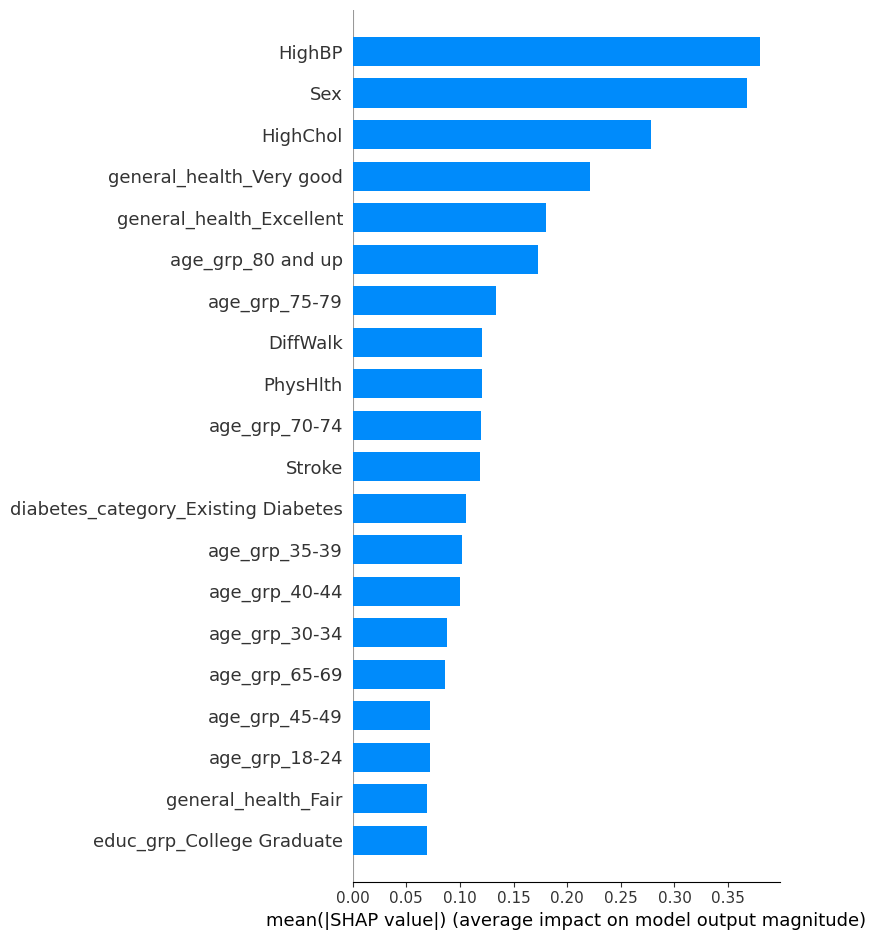

In [25]:
shap.initjs()

model = rh['gradientboostingclassifier']
explainer = shap.TreeExplainer(model, feature_names=X_holdout.columns)
shap_values = explainer.shap_values(X_holdout, check_additivity=False)
shap.summary_plot(shap_values, X_holdout.columns, plot_type='bar')

  0%|          | 0/44083 [00:00<?, ?it/s]

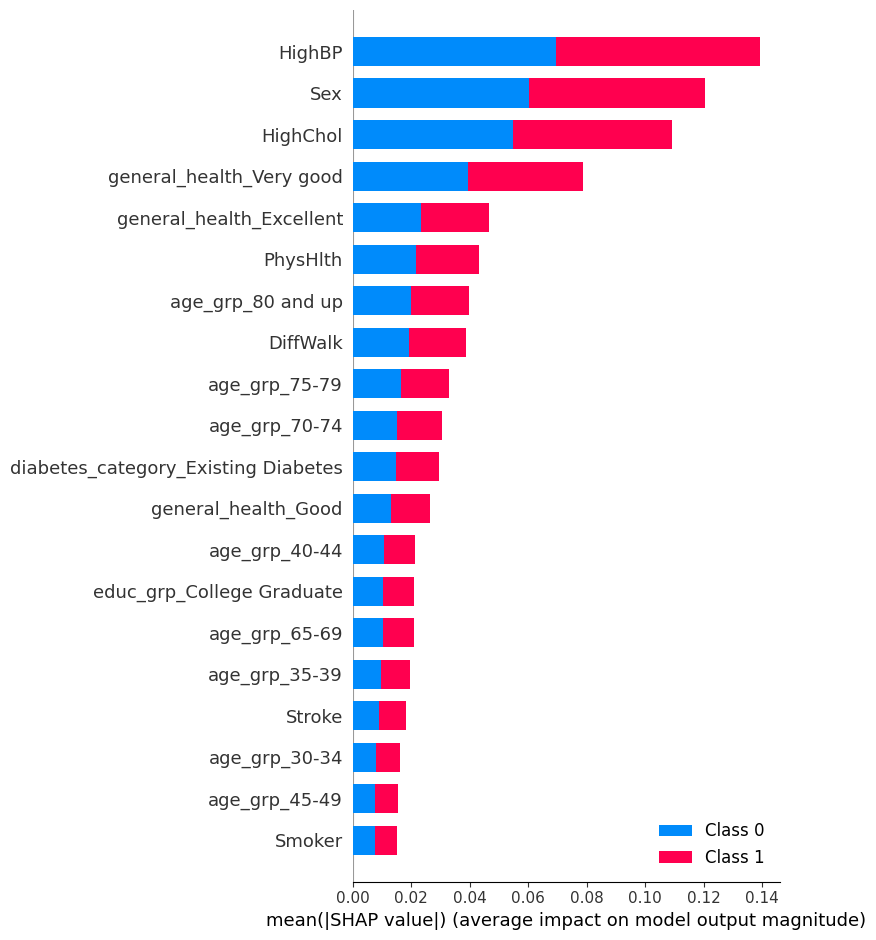

In [27]:
shap.initjs()

model = rh['gradientboostingclassifier']
background_data = shap.kmeans(X_trainval, 10)
explainer = shap.KernelExplainer(model.predict_proba, background_data)
shap_values = explainer.shap_values(X_holdout)
shap.summary_plot(shap_values, X_holdout)

#### Beeswarm

 99%|===================| 43771/44083 [01:25<00:00]        

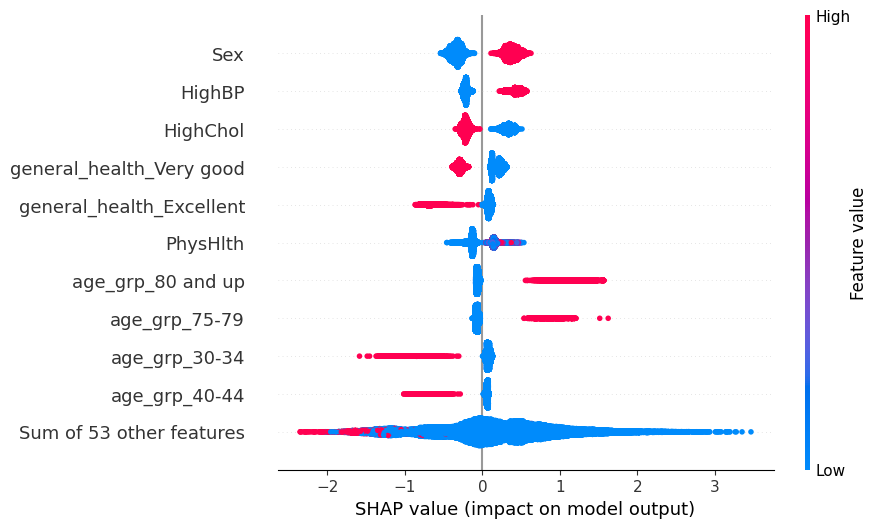

In [43]:
explainer1 = shap.Explainer(model, X_holdout)
shap_values = explainer1(X_holdout)

shap.plots.beeswarm(shap_values, max_display=11)

100%|===================| 43983/44083 [01:27<00:00]        

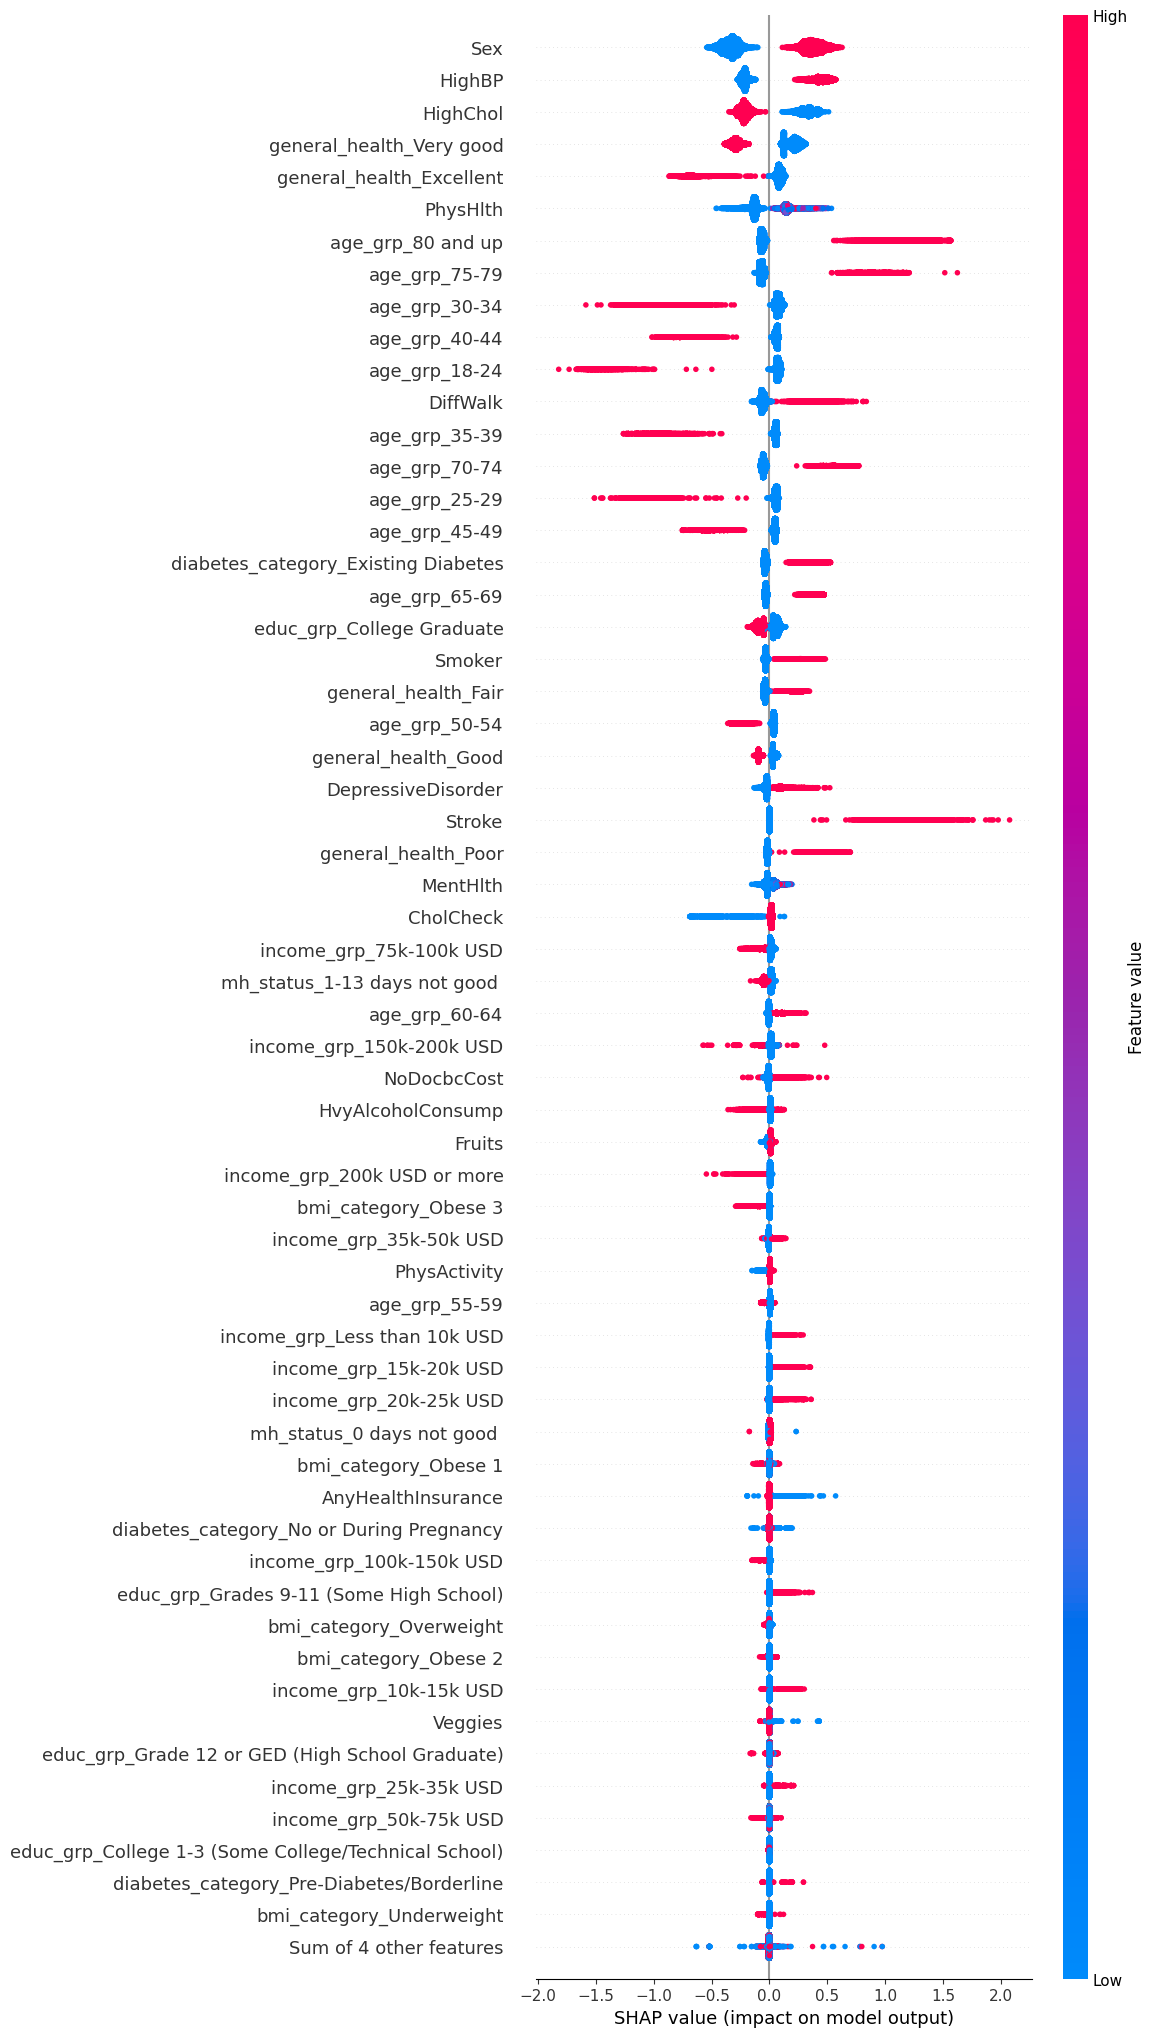

In [41]:
explainer1 = shap.Explainer(model, X_holdout)
shap_values = explainer1(X_holdout)

shap.plots.beeswarm(shap_values, max_display=60)

#### Waterfall

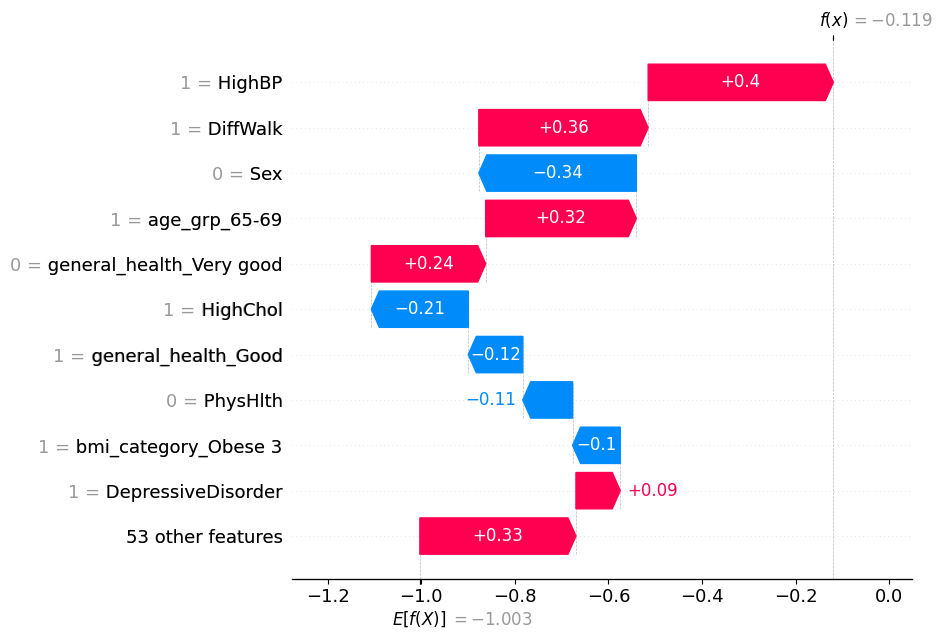

In [39]:
shap.plots.waterfall(shap_values[0], max_display=11)